# Simulator Response Comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from numba import jit

%matplotlib inline

/home/nas/anaconda2/envs/cochlea/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Assumes times are ordered
@jit(nopython=True)
def get_ISIs(ids, times, num_neurons=3200):
    ISIs = np.empty((np.sum(ids < num_neurons)))
    currentloc = 0
    num_responsive_neurons = 0
    for n in range(num_neurons):
        indv_neuronspikes = np.sort(times[ids == n])
        numiterate = len(indv_neuronspikes) - 1
        if (numiterate > 0):
            num_responsive_neurons += 1
            difference = indv_neuronspikes[1:] - indv_neuronspikes[0:-1]
            ISIs[currentloc:(currentloc + numiterate)] = difference
            currentloc += numiterate
    return (ISIs[:-num_responsive_neurons])

def get_rates(ids, times, num_neurons=3200, starttime=50.0, endtime=100.0):
    neuronrates = np.empty(num_neurons)
    mask = times > 50.0
    for n in range(num_neurons):
        num_spikes = np.sum(ids[mask] == (n))
        neuronrates[n] = num_spikes / 50.0
    return (neuronrates)

### Loading Auryn firing times

In [3]:
ls ../auryn/

Build/             elapsed.dat               sim_coba_benchmark.1.log
coba.0.e.ras       Makefile                  sim_coba_benchmark.cpp
coba.0.i.ras       sim_coba_benchmark*       test/
coba_e_merged.ras  sim_coba_benchmark.0.log  timefile.dat


In [4]:
auryn_df = pd.read_csv("../auryn/coba.0.e.ras", delim_whitespace=True, header=None, names=["times", "ids"])

In [5]:
# Calculate ISIs
auryn_ISIs = get_ISIs(auryn_df["ids"].values, auryn_df["times"].values)
# Calculating firing rates for the last 50s
auryn_neuronrates = get_rates(auryn_df["ids"].values, auryn_df["times"].values)

In [6]:
auryn_data = {
    "name": "Auryn",
    "spikes": auryn_df,
    "ISIs": auryn_ISIs,
    "rates": auryn_neuronrates
}

In [7]:
np.mean(auryn_neuronrates)

17.31693125

### Loading Nest firing times

In [8]:
ls ../pyNest/

Build/  COBA.py  setpaths.sh*  timefile.dat  va-py-ex-4001-0.gdf


In [9]:
nest_df = pd.read_csv("../pyNest/va-py-ex-4001-0.gdf", delim_whitespace=True, header=None, names=["ids", "times"])

In [10]:
# Bring nest timing into seconds
nest_df["times"] /= 1000.0

In [11]:
# Calculate ISIs
nest_ISIs = get_ISIs(nest_df["ids"].values - 1, nest_df["times"].values)
# Calculating firing rates for the last 50s
nest_neuronrates = get_rates(nest_df["ids"].values - 1, nest_df["times"].values)

In [12]:
nest_data = {
    "name": "Nest",
    "spikes": nest_df,
    "ISIs": nest_ISIs,
    "rates": nest_neuronrates
}

In [13]:
np.mean(nest_neuronrates)

17.113856250000001

### Loading Spike firing times

In [14]:
ls ../Spike/Build/output/

Neurons_SpikeIDs_Untrained_Epoch0.bin  Neurons_SpikeTimes_Untrained_Epoch0.bin


In [15]:
idsfile = "../Spike/Build/output/Neurons_SpikeIDs_Untrained_Epoch0.bin"
timesfile = "../Spike/Build/output/Neurons_SpikeTimes_Untrained_Epoch0.bin"
spike_df = pd.DataFrame(data = {"ids": np.fromfile(idsfile, dtype=np.int32), "times": np.fromfile(timesfile, dtype=np.float32)})


In [16]:
# Calculate ISIs
spike_ISIs = get_ISIs(spike_df["ids"].values, spike_df["times"].values)
# Calculating firing rates for the last 50s
spike_neuronrates = get_rates(spike_df["ids"].values, spike_df["times"].values)

In [17]:
spike_data = {
    "name": "Spike",
    "spikes": spike_df,
    "ISIs": spike_ISIs,
    "rates": spike_neuronrates
}

In [18]:
np.mean(spike_neuronrates)

17.337900000000001

### Loading ANNarchy firing times

In [104]:
ls ../ANNarchy/

annarchy/  COBA.py  spikes.out  timefile.dat


In [105]:
spikesfile = "../ANNarchy/spikes.out"
annarchy_df = pd.read_csv(spikesfile, delim_whitespace=True, header=None, names=["ids", "times"])

In [106]:
# Bring ANNarchy timing into seconds
annarchy_df["times"] /= 10000.0

In [22]:
# Calculate ISIs
annarchy_ISIs = get_ISIs(annarchy_df["ids"].values, annarchy_df["times"].values)
# Calculating firing rates for the last 50s
annarchy_neuronrates = get_rates(annarchy_df["ids"].values, annarchy_df["times"].values)

In [107]:
annarchy_data = {
    "name": "ANNarchy",
    "spikes": annarchy_df,
    "ISIs": annarchy_ISIs,
    "rates": annarchy_neuronrates
}

In [108]:
np.mean(annarchy_neuronrates)

17.1715625

### Loading Brian2 firing times

In [25]:
ls ../brian2/

COBA.py  spikes.out  timefile.dat


In [26]:
spikesfile = "../brian2/spikes.out"
brian2_df = pd.read_csv(spikesfile, delim_whitespace=True, header=None, names=["ids", "times"])

In [27]:
# Calculate ISIs
brian2_ISIs = get_ISIs(brian2_df["ids"].values, brian2_df["times"].values)
# Calculating firing rates for the last 50s
brian2_neuronrates = get_rates(brian2_df["ids"].values, brian2_df["times"].values)

In [28]:
brian2_data = {
    "name": "Brian2",
    "spikes": brian2_df,
    "ISIs": brian2_ISIs,
    "rates": brian2_neuronrates
}

In [29]:
np.mean(brian2_neuronrates)

23.866274999999995

## Comparing Simulators

In [111]:
simulator_data = [
    nest_data,
    spike_data,
    auryn_data,
    annarchy_data,
    brian2_data
]

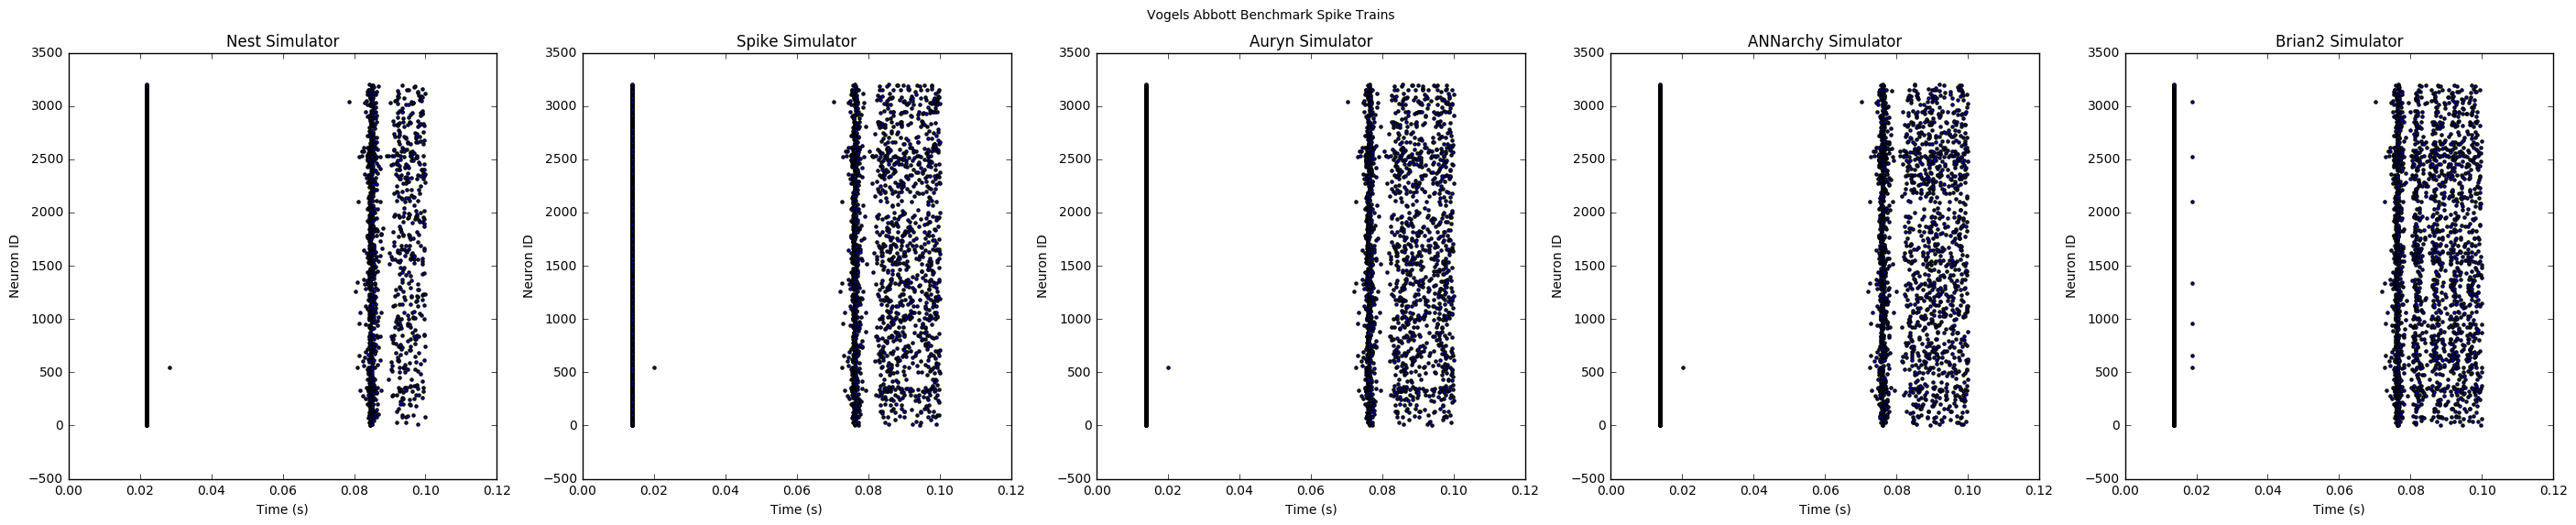

In [112]:
fig = plt.figure(figsize=(35, 6))

for index, data in enumerate(simulator_data):
    ax = plt.subplot(1, len(simulator_data), index + 1)
    mask = (data["spikes"]["times"] > 0.0) & (data["spikes"]["times"] < 0.1) & (data["spikes"]["ids"] < 3200)
    ax.scatter(data["spikes"]["times"][mask], data["spikes"]["ids"][mask], marker='.')
    ax.set_title(data["name"] + " Simulator")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Neuron ID")
    ax.set_xlim([0.0, 0.12])

fig.suptitle('Vogels Abbott Benchmark Spike Trains')

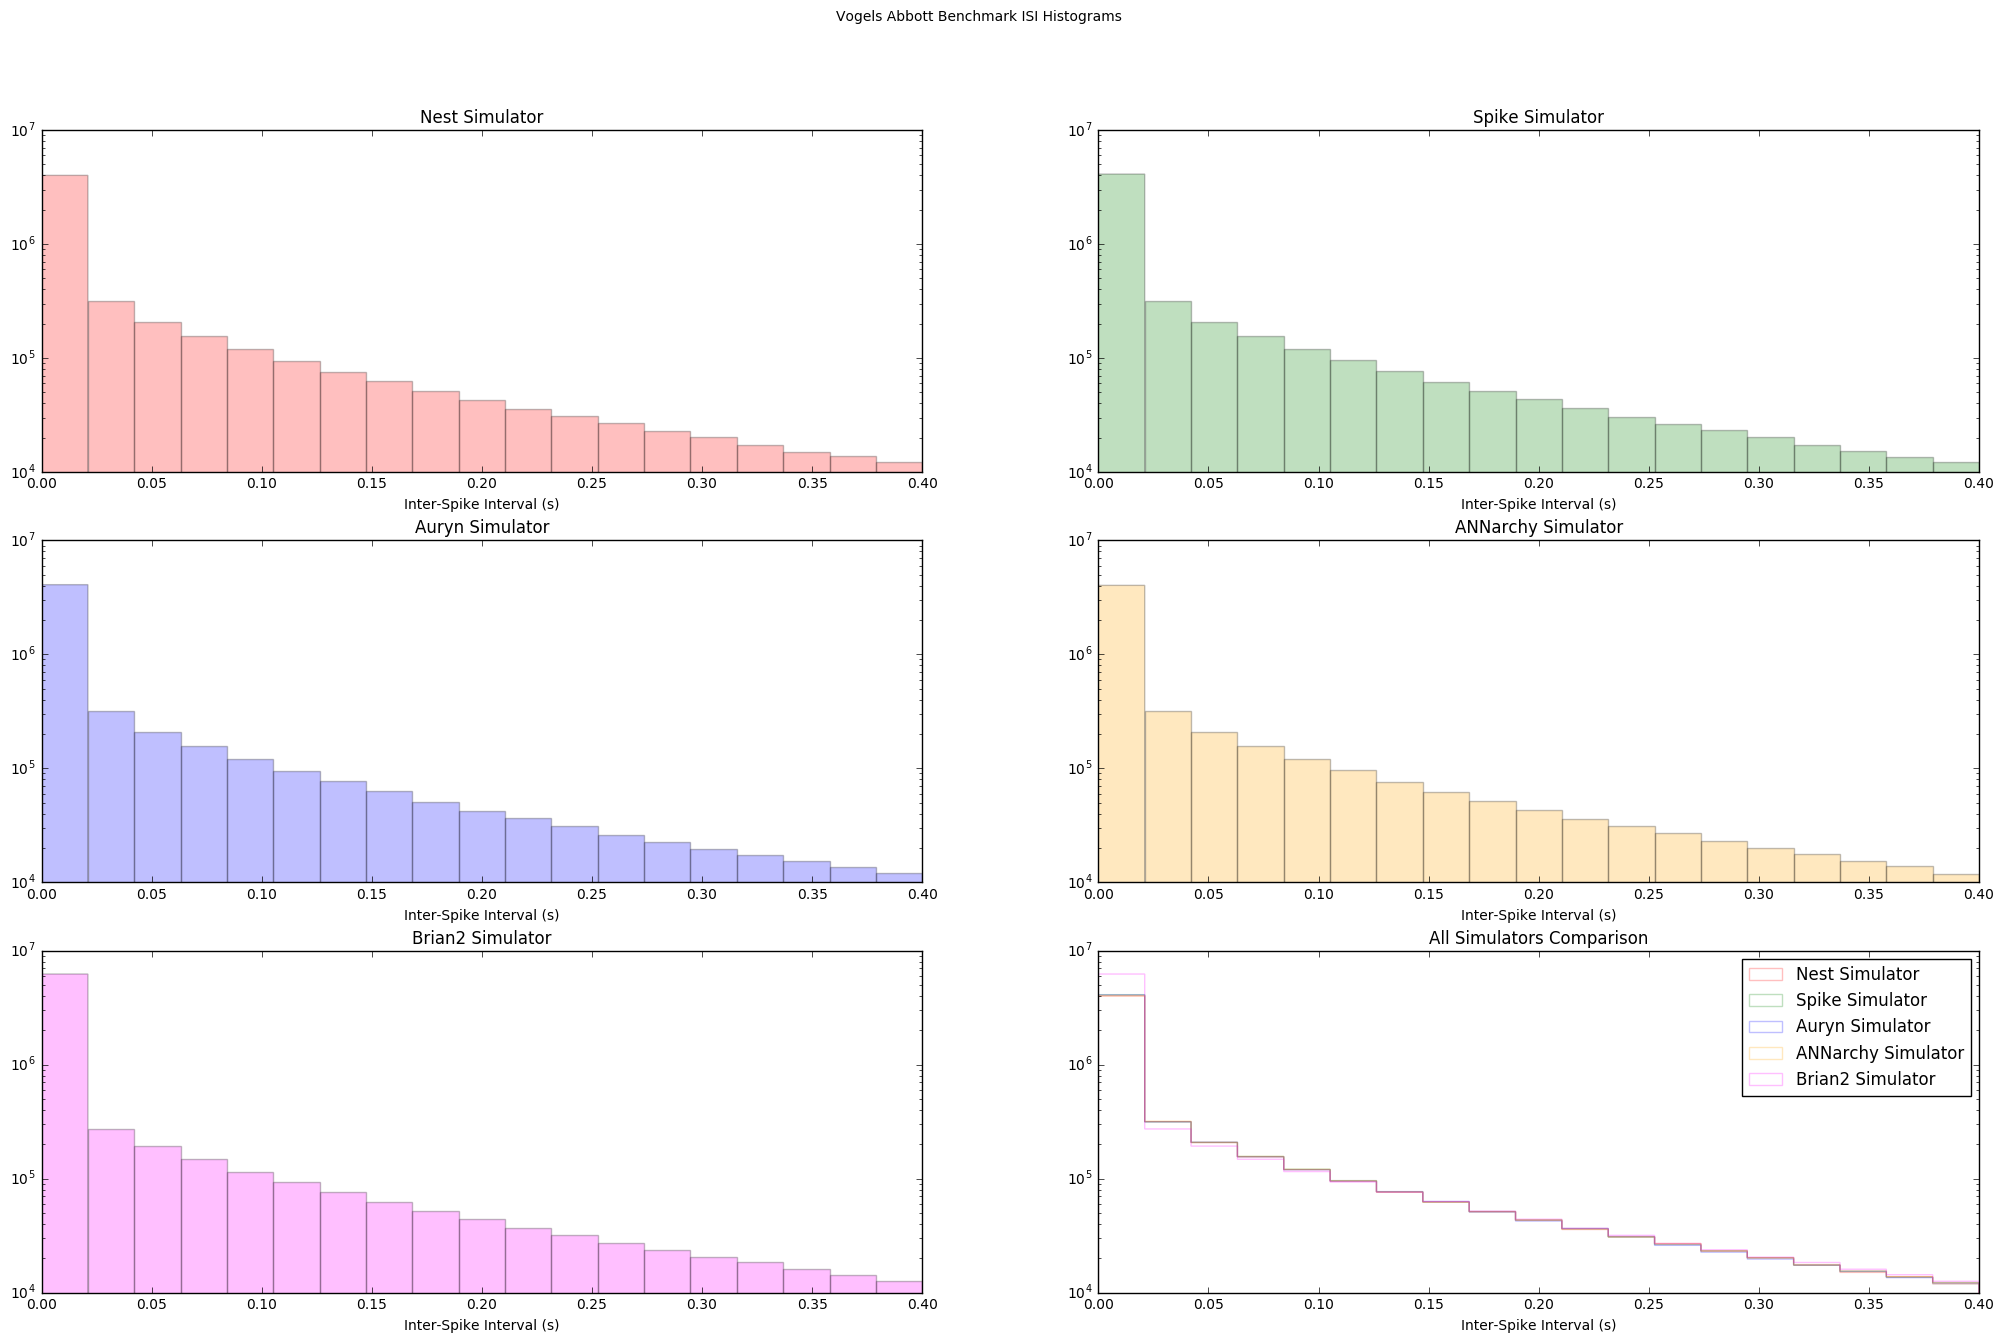

In [32]:
binvals = np.linspace(0.0, 0.4, 20)
colours = ['red', 'green', 'blue', 'orange', 'magenta', 'black']
fig = plt.figure(figsize=(25, 15))
num_rows = 3

#Individual ISI plots
for index, data in enumerate(simulator_data):
    ax = plt.subplot(num_rows, int(np.ceil(float(len(simulator_data) + 1) / num_rows)), index + 1)
    ax.set_yscale('log')
    ax.hist(np.asarray(data["ISIs"]), bins=binvals, label=(data["name"] + " Simulator"), alpha=0.25, color=colours[index])
    ax.set_title(data["name"] + " Simulator")
    ax.set_xlabel("Inter-Spike Interval (s)")
    ax.set_xlim([0.00, 0.40])
    ax.set_ylim([10**4, 10**7])


# Combined ISI plot
all_ax = plt.subplot(num_rows, int(np.ceil(float(len(simulator_data) + 1) / num_rows)), (num_rows * int(np.ceil(float(len(simulator_data) + 1) / num_rows))))
for index, data in enumerate(simulator_data):
    all_ax.hist(np.asarray(data["ISIs"]), bins=binvals, label=(data["name"] + " Simulator"), alpha=0.25, color=colours[index], histtype=u'step')
all_ax.set_title("All Simulators Comparison")
all_ax.set_xlabel("Inter-Spike Interval (s)")
all_ax.set_yscale('log')
all_ax.set_ylim([10**4, 10**7])
all_ax.set_xlim([0.00, 0.40])
all_ax.legend()

fig.suptitle('Vogels Abbott Benchmark ISI Histograms')

In the plots above, note that the simulators have close to identical ISI distributions except for Brian2 and Brian2GeNN

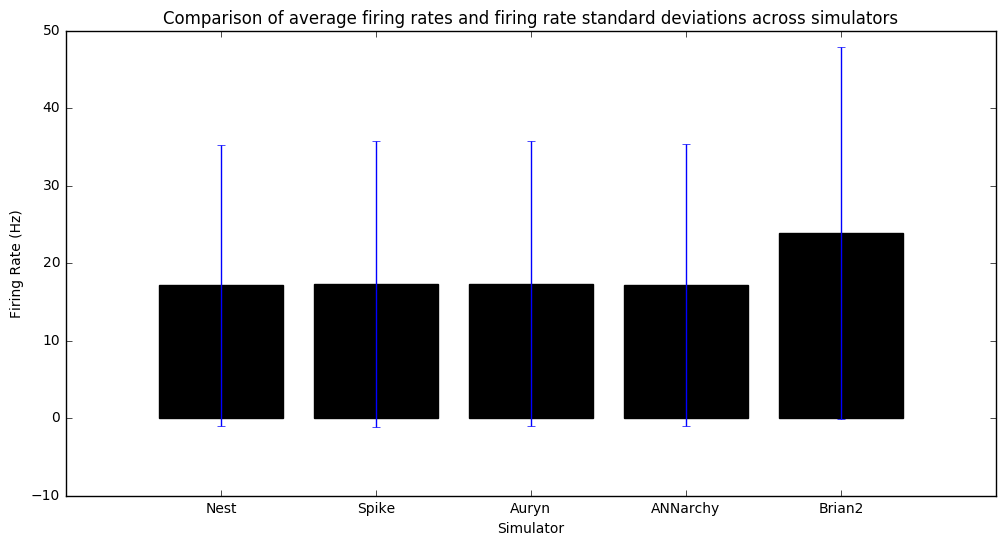

In [33]:
fig = plt.figure(figsize=(12, 6))

meanrates = []
ratestd = []
labelstrings = []

for index, data in enumerate(simulator_data):
    meanrates.append(np.mean(data["rates"]))
    ratestd.append(np.std(data["rates"]))
    labelstrings.append(data["name"])

plt.bar(range(len(simulator_data)), meanrates, yerr=ratestd, color="k", align='center')
plt.xticks(range(len(simulator_data)), labelstrings)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Simulator")
plt.title("Comparison of average firing rates and firing rate standard deviations across simulators")

In [115]:
idsfile = "../Spike/Build/output/Neurons_SpikeIDs_Untrained_Epoch0.bin"
timesfile = "../Spike/Build/output/Neurons_SpikeTimes_Untrained_Epoch0.bin"
spike_df = pd.DataFrame(data = {"ids": np.fromfile(idsfile, dtype=np.int32), "times": np.fromfile(timesfile, dtype=np.float32)})


In [116]:
# Calculate ISIs
spike_ISIs = get_ISIs(spike_df["ids"].values, spike_df["times"].values)
# Calculating firing rates for the last 50s
spike_neuronrates = get_rates(spike_df["ids"].values, spike_df["times"].values)

KeyboardInterrupt: 

In [117]:
spike_data = {
    "name": "Spike",
    "spikes": spike_df,
    "ISIs": spike_ISIs,
    "rates": spike_neuronrates
}

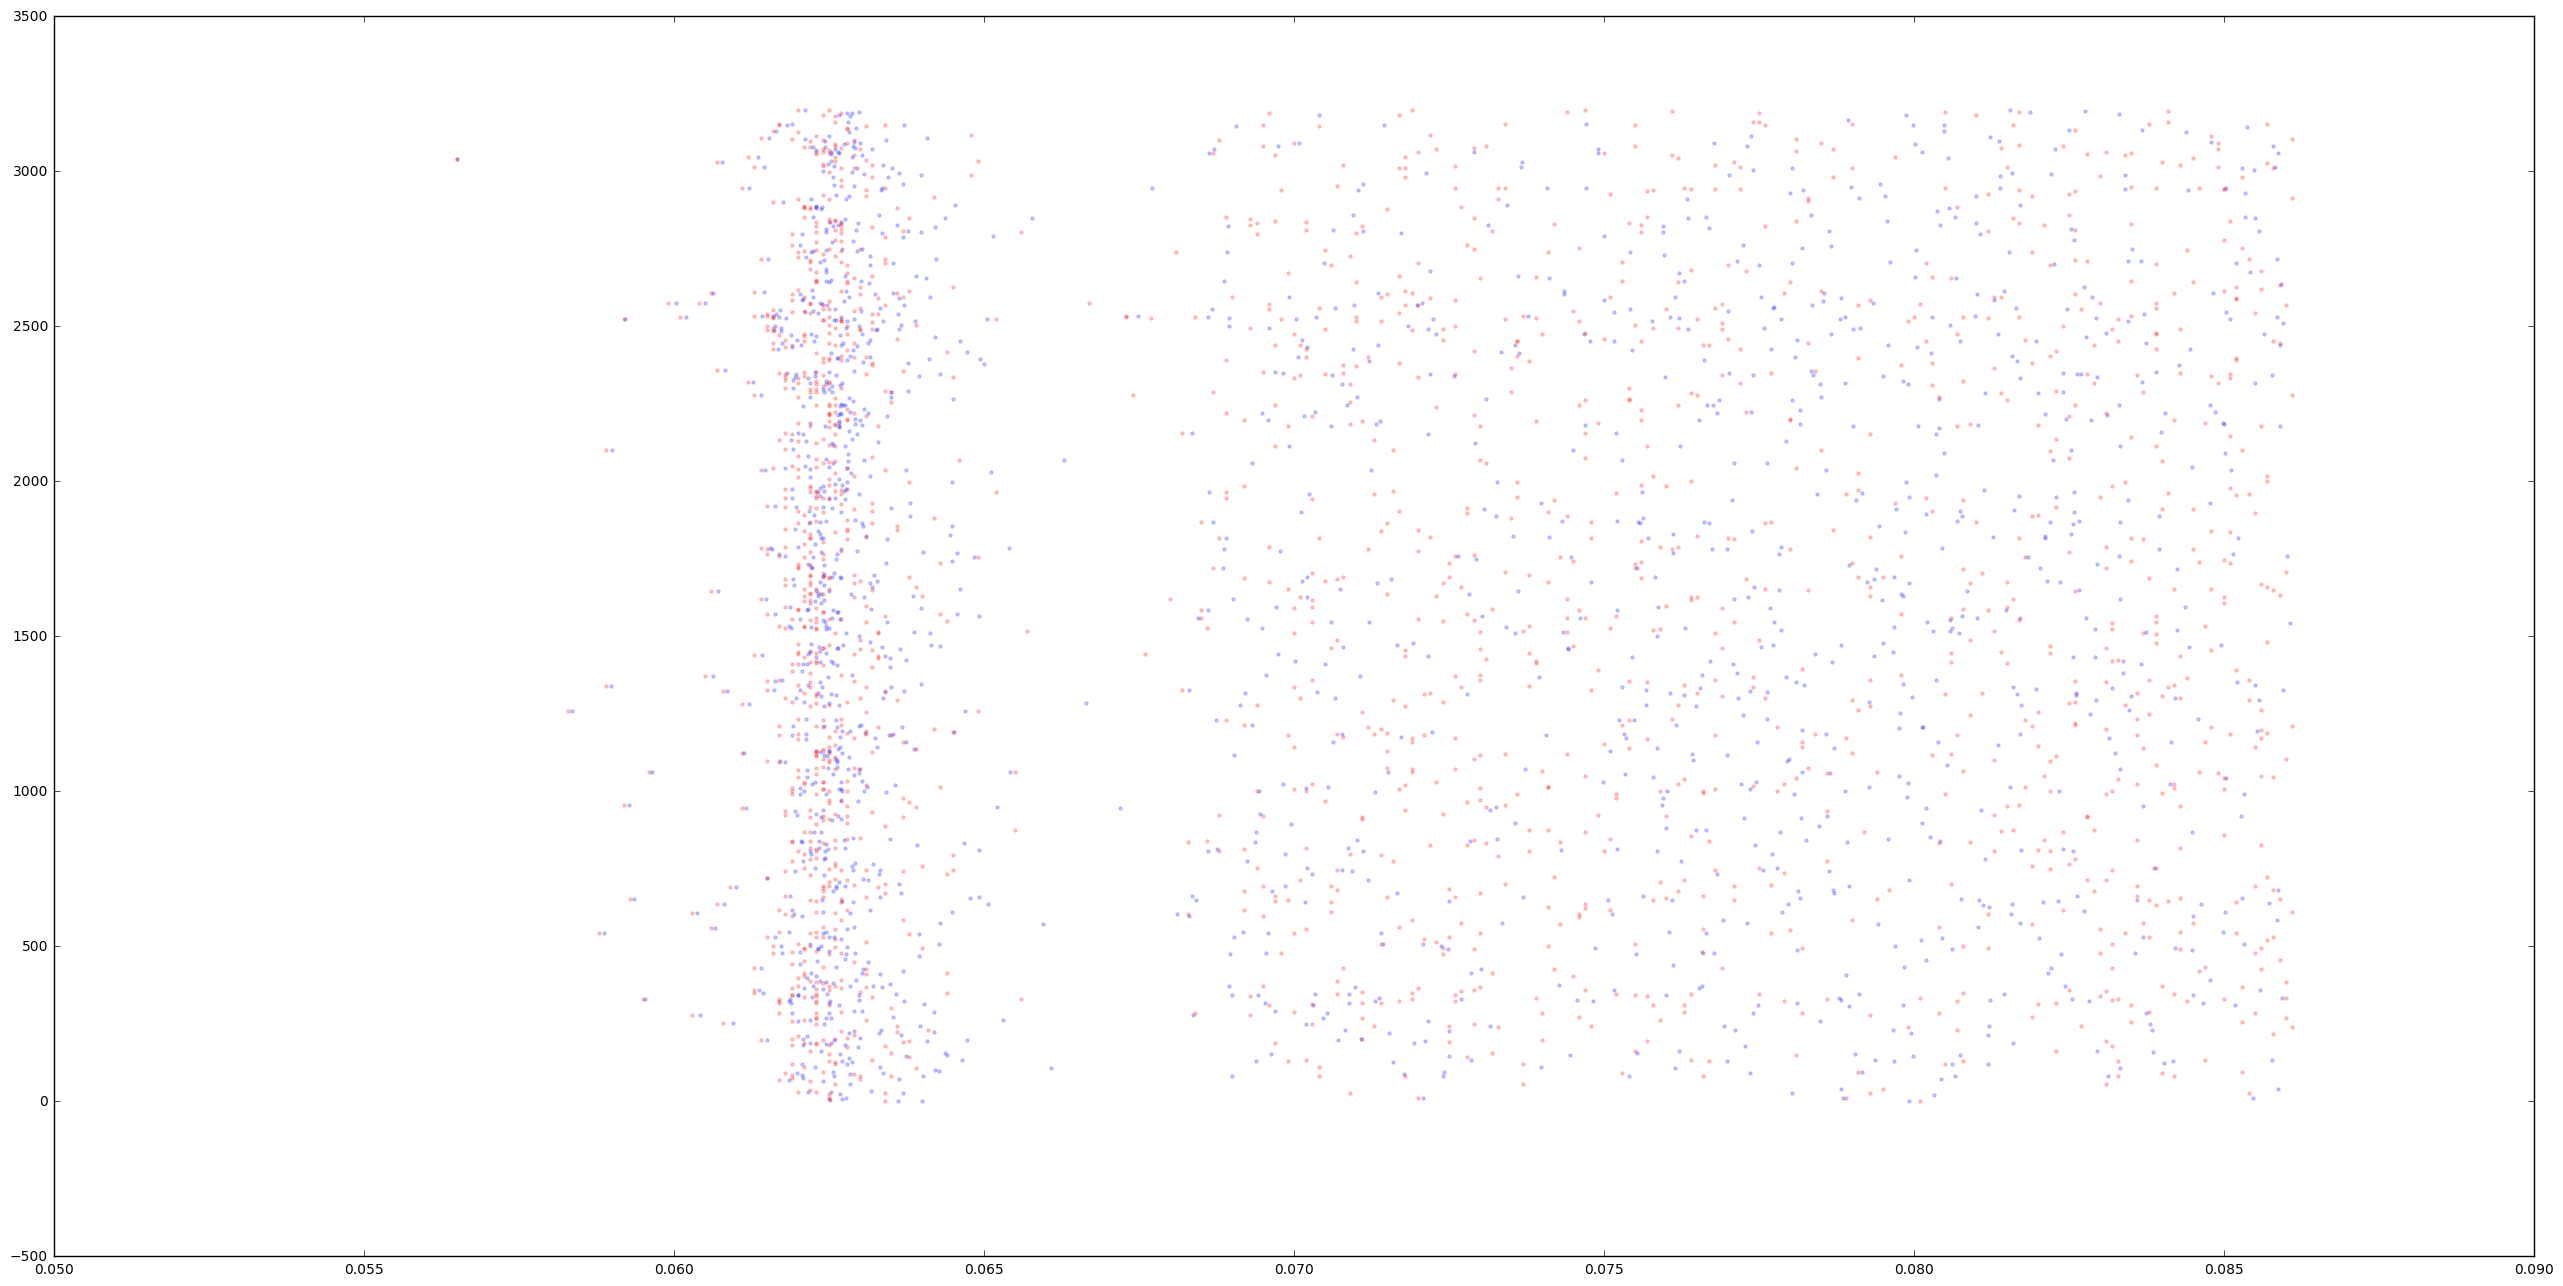

In [120]:
plt.figure(figsize=(32,16))
mask = (spike_data["spikes"]["times"] > 0.05) & (spike_data["spikes"]["times"] < 0.1) & (spike_data["spikes"]["ids"] < 3200)
timeshift = np.min(spike_data["spikes"]["times"])
plt.scatter(spike_data["spikes"]["times"][mask] - timeshift, spike_data["spikes"]["ids"][mask], marker='.', color='b', alpha=0.2)

timeshift = np.min(auryn_data["spikes"]["times"])
mask = (auryn_data["spikes"]["times"] > 0.05) & (auryn_data["spikes"]["times"] < 0.1) & (auryn_data["spikes"]["ids"] < 3200)
plt.scatter(auryn_data["spikes"]["times"][mask] - timeshift, auryn_data["spikes"]["ids"][mask], marker='.', color='r', alpha=0.2)

# timeshift = np.min(annarchy_data["spikes"]["times"])
# mask = (annarchy_data["spikes"]["times"] > 0.0) & (annarchy_data["spikes"]["times"] < 0.1) & (annarchy_data["spikes"]["ids"] < 3200)
# plt.scatter(annarchy_data["spikes"]["times"][mask] - timeshift, annarchy_data["spikes"]["ids"][mask] - 1, marker='.', color='g', alpha=0.2)

# timeshift = np.min(nest_data["spikes"]["times"])
# mask = (nest_data["spikes"]["times"] > 0.05) & (nest_data["spikes"]["times"] < 0.1) & (nest_data["spikes"]["ids"] < 3200)
# plt.scatter(nest_data["spikes"]["times"][mask] - timeshift, nest_data["spikes"]["ids"][mask] - 1, marker='.', color='g', alpha=0.2)

In [93]:
np.min(spike_data["spikes"]["times"])

0.0138

In [94]:
np.min(auryn_data["ISIs"][:-1])

0.00549999999999784

In [95]:
np.min(spike_data["ISIs"][:-1])

0.0053997039794921875

In [96]:
np.mean(spike_data["rates"])

17.370706249999998